**Sentiment-Based Product Review Analysis**

Import libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load and Explore the Dataset

In [12]:
# Load the dataset
data = pd.read_csv('/root/.cache/kagglehub/datasets/datafiniti/consumer-reviews-of-amazon-products/versions/5/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', encoding='latin-1')

# Select relevant columns
data = data[['reviews.text', 'reviews.rating']]

# Rename columns for clarity
data.columns = ['review', 'rating']

# Check for missing values and basic info
print(data.info())
print(data['rating'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  5000 non-null   object
 1   rating  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB
None
rating
5    3478
4    1208
3     197
1      63
2      54
Name: count, dtype: int64


Create Sentiment Labels

In [16]:
# Create sentiment labels
def rating_to_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

data['sentiment'] = data['rating'].apply(rating_to_sentiment)

# Check sentiment distribution
print(data['sentiment'].value_counts())

sentiment
2    4686
1     197
0     117
Name: count, dtype: int64


Preprocess the Text Data

In [18]:
# Initialize stemmer and stopwords
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return ''
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_review'] = data['review'].apply(preprocess_text)

# View a few processed reviews
print(data[['review', 'processed_review']].head())

                                              review  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                    processed_review  
0  thought would big small paper turn like palm t...  
1                  kindl light easi use especi beach  
2  didnt know much use kindl went lower end im ha...  
3  happi purchas caught sale realli good price no...  
4  solid entri level kindl great kid gift kid fri...  


Feature Extraction

In [8]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Transform the processed text
X = tfidf.fit_transform(data['processed_review']).toarray()
y = data['sentiment']

# Check the shape
print(X.shape)

(5000, 3534)


Split the Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (4000, 3534)
Testing set size: (1000, 3534)


Train and Evaluate a Model

In [10]:
# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_pred=y_pred, y_true=y_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.937

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.88      0.94      0.91      1000


Confusion Matrix:
 [[  0   0  24]
 [  0   0  39]
 [  0   0 937]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualize Results

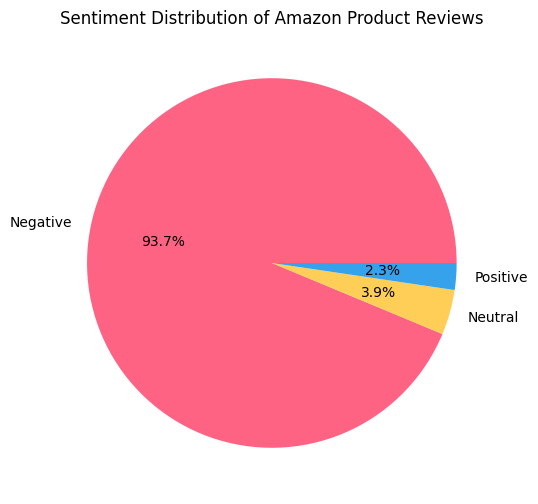

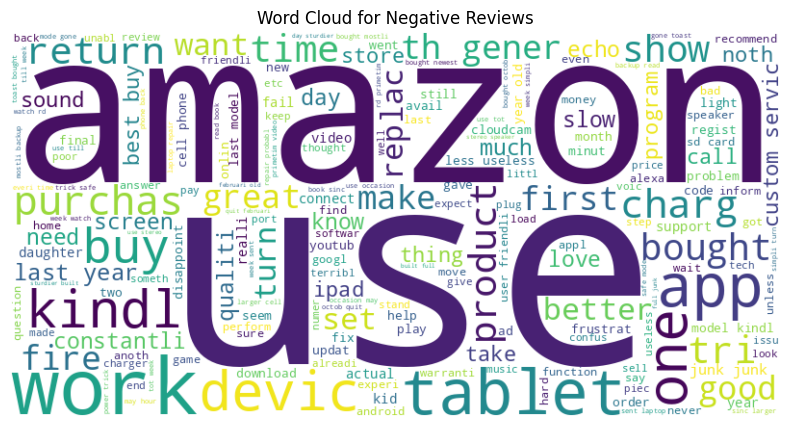

In [11]:
# Pie chart for sentiment distribution
sentiment_counts = data['sentiment'].value_counts()
labels = ['Negative', 'Neutral', 'Positive']
colors = ['#FF6384', '#FFCE56', '#36A2EB']

plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution of Amazon Product Reviews')
plt.show()

# Word cloud for negative reviews
negative_reviews = ' '.join(data[data['sentiment'] == 0]['processed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

Top 10 frequent words in negative reviews: [('use', 56), ('amazon', 39), ('work', 33), ('tablet', 33), ('bought', 30), ('app', 30), ('kindl', 28), ('buy', 27), ('one', 25), ('devic', 24)]


<ipython-input-19-029b5a115ed8>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Reds')


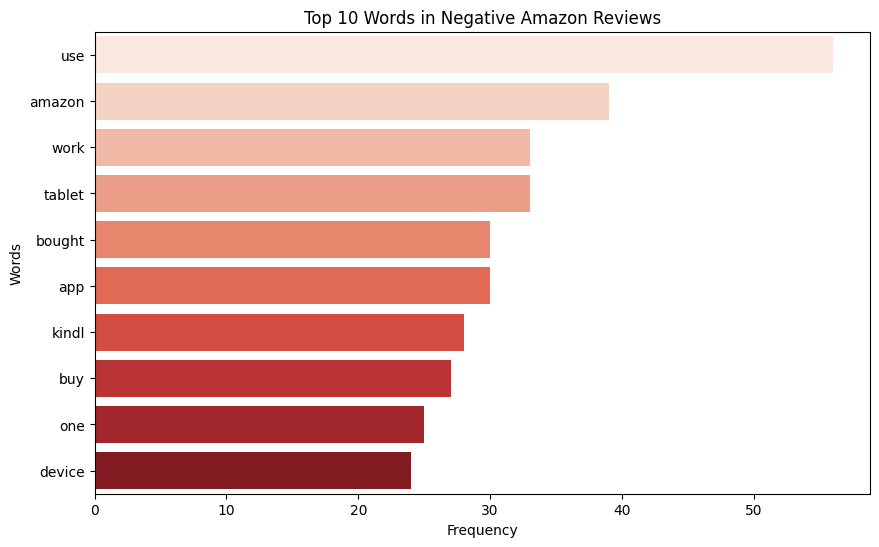

Percentage of negative reviews mentioning 'battery': 4.27%
Percentage of negative reviews mentioning 'defective': 5.13%
Percentage of negative reviews mentioning 'poor': 5.98%
Percentage of negative reviews mentioning 'quality': 8.55%

Sample negative reviews mentioning 'battery':
1: It was too slow he didn't put any attention to it. Battery didn't last.
2: This is not an upgrade by any means! My three year old kindle outperformed Oasis.Battery life better than a week with the lights on lowest setting Magnetic connector is poorly designed and grows weak Two pieces to keep up with; unsnaps constantly Amazon Customer Services promises it will resolved in an update
3: Not a good product short battery life i can only use for 20 minutes
4: This is not an upgrade by any means! My three year old kindle outperformed Oasis.Battery life better than a week with the lights on lowest setting Magnetic connector is poorly designed and grows weak Two pieces to keep up with; unsnaps constantly Amazon C

In [19]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- Extract Frequent Words in Negative Reviews ---
# Filter negative reviews (sentiment = 0)
negative_reviews = data[data['sentiment'] == 0]['processed_review']

# Combine negative reviews into a single string and tokenize
negative_text = ' '.join(negative_reviews)
negative_tokens = word_tokenize(negative_text)

# Count word frequencies
word_counts = Counter(negative_tokens)

# Get the top 10 most frequent words
top_words = word_counts.most_common(10)
print("Top 10 frequent words in negative reviews:", top_words)

# Map stemmed words to likely original forms (manual mapping for common stems)
stem_to_word = {
    'batteri': 'battery',
    'defect': 'defective',
    'qualiti': 'quality',
    'poor': 'poor',
    'broke': 'broken',
    'work': 'work',
    'screen': 'screen',
    'product': 'product',
    'charg': 'charge',
    'devic': 'device'
}
top_words_mapped = [(stem_to_word.get(word, word), count) for word, count in top_words]

# --- Visualize Top Words with Bar Chart ---
words, counts = zip(*top_words_mapped)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='Reds')
plt.title('Top 10 Words in Negative Amazon Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# --- Calculate Percentage of Negative Reviews Mentioning Key Terms ---
total_negative = len(negative_reviews)
key_terms = ['batteri', 'defect', 'poor', 'qualiti']
for term in key_terms:
    term_count = sum(1 for review in negative_reviews if term in review)
    percentage = (term_count / total_negative) * 100
    print(f"Percentage of negative reviews mentioning '{stem_to_word.get(term, term)}': {percentage:.2f}%")

# --- Sample Negative Reviews for Context ---
print("\nSample negative reviews mentioning 'battery':")
sample_reviews = data[data['processed_review'].str.contains('batteri') & (data['sentiment'] == 0)]['review'].head(5)
for idx, review in enumerate(sample_reviews):
    print(f"{idx+1}: {review}")

# --- Insights for Product Improvements ---
print("\nInsights for Product Improvements:")
print("- Battery Issues: The term 'battery' is frequent in negative reviews, indicating short battery life or failure. Recommendation: Enhance battery quality and test longevity under real-world conditions.")
print("- Defective Products: Words like 'defective' and 'broken' suggest manufacturing issues. Recommendation: Implement stricter quality control and improve customer support for replacements.")
print("- Poor Quality: Terms like 'poor' and 'quality' indicate dissatisfaction with materials or performance. Recommendation: Upgrade materials and prioritize durability in product design.")

# --- Address Class Imbalance (Optional) ---
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Retrain model
model_res = MultinomialNB()
model_res.fit(X_train_res, y_train_res)

# Evaluate retrained model
y_pred_res = model_res.predict(X_test_res)
print("\nAccuracy after SMOTE:", accuracy_score(y_test_res, y_pred_res))
print("\nClassification Report after SMOTE:\n", classification_report(y_test_res, y_pred_res))
print("\nConfusion Matrix after SMOTE:\n", confusion_matrix(y_test_res, y_pred_res))